# Create data for stacking code testing

In [1]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes

In [2]:
data_path = Path("/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/")
my_path = Path("/global/cscratch1/sd/bid13/stack-spectra")

In [3]:
tile = "80609"
tile_path = data_path / tile /"deep"

In [ ]:
z_table = Table()
spectra = desispec.spectra.Spectra()

for file_path in tile_path.glob("zbest-*"):

    z_petal = Table.read(file_path, hdu="ZBEST")
    fibermap_petal = Table.read(file_path, hdu="FIBERMAP")[0:500]

    merged_table = join(z_petal, fibermap_petal, keys="TARGETID", metadata_conflicts="silent")
    print(len(merged_table))
    mask = ((merged_table["SV1_DESI_TARGET"] & desi_mask.mask("LRG"))>0) & (merged_table["FIBERSTATUS"] == 0)
    mask &= (merged_table["Z"]>0.9) & (merged_table["Z"]<1)
    mask &= (merged_table["SPECTYPE"]=="GALAXY")
    mask &= (merged_table["DELTACHI2"]>15)
    merged_table = merged_table[mask]
    

    if np.sum(mask):
        spec = desispec.io.read_spectra(str(file_path).replace("zbest","coadd") )
        # CAUTION desispec uses EXPID + FIBER to determine uniqueness
        spec.fibermap["NIGHT"] = np.arange(len(spec.fibermap))
        spec.fibermap["EXPID"] = np.arange(len(spec.fibermap))
        spec = spec.select(targets= merged_table["TARGETID"])

        z_table = vstack([z_table, merged_table])
        spectra.update(spec)

In [ ]:
len(z_table)

In [ ]:
spectra.num_targets()

In [ ]:
_=plt.hist(z_table["Z"], histtype="step", color="k", bins=50)
plt.xlabel("Spec-Z")

In [ ]:
z_table.write(my_path/"zcat.fits")
desispec.io.write_spectra(my_path/"spectra.fits", spectra)

In [ ]:
spectra = coadd_cameras(spectra) #Coadding the cameras now but needs to be treated separately in future
                                # Moreover this needs a whole DESI spectra object and is very slow. Possible way out is to reimplrment a lighter version of this.
desispec.io.write_spectra(my_path / "spectra_coadd_cam.fits", spectra)

In [5]:
sky = desispec.io.read_spectra("/global/cfs/cdirs/desi/spectro/redux/cascades/tiles/80609/deep/coadd-0-80609-deep.fits")

INFO:spectra.py:253:read_spectra: iotime 0.758 sec to read coadd-0-80609-deep.fits at 2021-04-01T15:28:56.568203


In [15]:
x = sky.flux["b"][sky.fibermap["OBJTYPE"]=="SKY"]

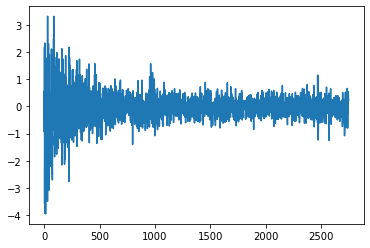

In [17]:
plt.plot(x[0])

# Curate the sky spectra